<a href="https://colab.research.google.com/github/emmanuelmadoery/IA_causal/blob/main/Atribuci%C3%B3n_del_efecto_indirecto_en_campa%C3%B1as_de_tr%C3%A1fico_mediante_IA_Causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librerías y Configurar el Entorno

In [ ]:
# Importar librerías
!pip install dowhy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import CausalModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 4.3 MB/s eta 0:00:00


Configurar la Semilla y el Número de **Observaciones**

In [ ]:
# Fijar la semilla para reproducibilidad
np.random.seed(42)

# Definir el número de observaciones (número de días, semanas o periodos analizados)
n = 1000

Generación del Dataset Sintético

In [ ]:
# Simular Demanda
# Esta variable refleja la demanda del mercado, que influye en las inversiones en Prospecting y Retargeting.
demanda = np.random.normal(0, 1, n)

# Simular Prospecting influenciada por Demanda
# La inversión en Prospecting depende directamente de la Demanda del mercado.
prospecting = 2000 + 500 * demanda + np.random.normal(0, 100, n)

# Simular Retargeting influenciada por Demanda y Prospecting
# La inversión en Retargeting depende de la Demanda del mercado y de la inversión en Prospecting.
retargeting = 500 + 300 * demanda + 0.5 * prospecting + np.random.normal(0, 50, n)

# Simular Ventas influenciadas por Demanda, Prospecting y Retargeting
# Las ventas son influenciadas directamente por la Demanda del mercado, la inversión en Prospecting
# y la inversión en Retargeting, con un componente de aleatoriedad.
ventas = (1000 +
          1500 * demanda +   # Efecto directo de Demanda
          3.0 * prospecting +       # Efecto directo de Prospecting
          4.0 * retargeting +       # Efecto de Retargeting
          np.random.normal(0, 1000, n))

# Crear el DataFrame con las variables simuladas
data = pd.DataFrame({
    'Demanda': demanda,
    'Prospecting': prospecting,
    'Retargeting': retargeting,
    'Ventas': ventas
})

# Mostrar las primeras filas del DataFrame
print(data.head())

    Demanda  Prospecting  Retargeting        Ventas
0  0.496714  2388.292620  1809.401642  14239.748101
1 -0.138264  2023.331218  1462.960385  11854.053730
2  0.647689  2329.807306  1819.589218  15825.706065
3  1.523030  2696.821250  2289.921506  22422.382216
4 -0.234153  1952.745644  1311.446076  12309.344299


Análisis con Regresión Lineal Tradicional

In [ ]:
# ----------------------------------
# REGRESIÓN LINEAL (enfoque tradicional)
# ----------------------------------

# Este modelo estima el impacto de prospecting en las ventas.
X_ols = data[['Demanda', 'Prospecting', 'Retargeting']]  # Variables independientes
y = data['Ventas']  # Variable dependiente (Ventas)
X_ols = sm.add_constant(X_ols)  # Añadir la constante para el modelo de regresión

# Ajustar el modelo de regresión lineal
model_ols = sm.OLS(y, X_ols).fit()

# Mostrar los resultados de la regresión lineal para prospecting
print("Resultados de la Regresión Lineal Tradicional para Prospecting:")
print(model_ols.summary())

# Extraer los coeficientes de prospecting e retargeting de la regresión lineal tradicional
coef_ct_ols = model_ols.params['Prospecting']
print(f"\nEfecto estimado de Prospecting por Regresión Lineal: {coef_ct_ols}")

Resultados de la Regresión Lineal Tradicional para Prospecting:
                            OLS Regression Results                            
Dep. Variable:                 Ventas   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     8171.
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:13:57   Log-Likelihood:                -8351.1
No. Observations:                1000   AIC:                         1.671e+04
Df Residuals:                     996   BIC:                         1.673e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Análisis Causal

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


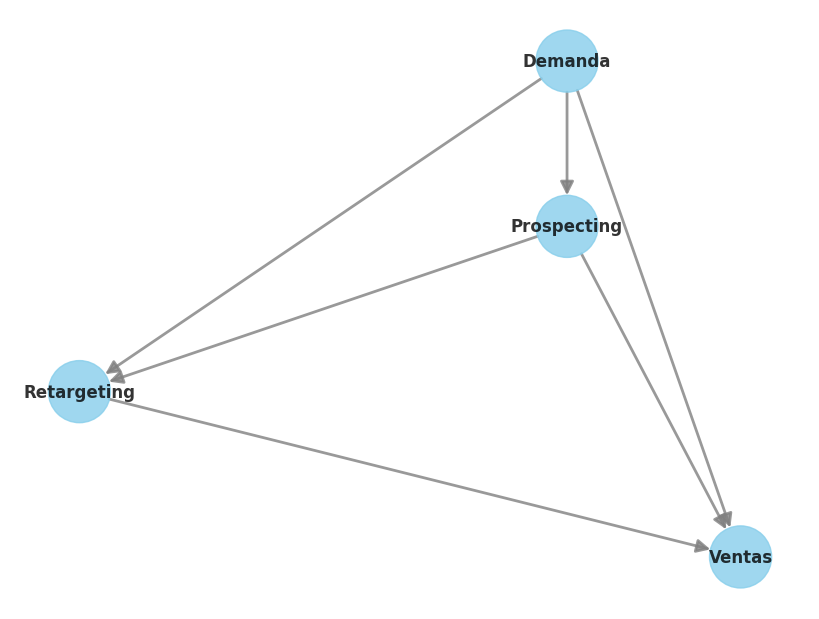

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
──────────────(E[Ventas|Demanda])
d[Prospecting]                   
Estimand assumption 1, Unconfoundedness: If U→{Prospecting} and U→Ventas then P(Ventas|Prospecting,Demanda,U) = P(Ventas|Prospecting,Demanda)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Estimación del efecto causal total de Prospecting en Ventas (Análisis Causal): 4.4099210964805025


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [ ]:
# ----------------------------------
# ANÁLISIS CAUSAL
# ----------------------------------

# Definir el grafo causal en formato DOT para representar las relaciones causales entre las variables
graph = """
digraph {
    Demanda;
    Prospecting;
    Retargeting;
    Ventas;

    Demanda -> Prospecting;
    Demanda -> Retargeting;
    Demanda -> Ventas;
    Prospecting -> Retargeting;
    Prospecting -> Ventas;
    Retargeting -> Ventas;
}
"""

# Crear el modelo causal para Prospecting
model_causal_ct = CausalModel(
    data=data,
    treatment='Prospecting',
    outcome='Ventas',
    graph=graph
)

# Visualizar el grafo causal
model_causal_ct.view_model(layout="dot")

# Identificar el estimando del efecto causal para Prospecting
# Este paso define las variables tratadas y los outcomes, buscando el efecto total de Prospecting sobre Ventas.
identified_estimand_ct = model_causal_ct.identify_effect()
print(identified_estimand_ct)

# Estimar el efecto causal total de Prospecting en Ventas (análisis causal)
# Este enfoque captura tanto el efecto directo como el indirecto de Prospecting en las ventas.
estimate_ct = model_causal_ct.estimate_effect(
    identified_estimand_ct,
    method_name="backdoor.linear_regression"
)
print(f"\nEstimación del efecto causal total de Prospecting en Ventas (Análisis Causal): {estimate_ct.value}")

Comparación de Resultados

In [ ]:
# Comparación de los resultados de ambos enfoques: Regresión Lineal Tradicional y Análisis Causal
# Aquí comparamos el efecto directo estimado por el modelo de regresión con el efecto total estimado por el análisis causal.

# Resultados para Prospecting
print(f"\nEfecto de Prospecting estimado por Regresión Lineal: {coef_ct_ols}")
print(f"Efecto de Prospecting estimado por Análisis Causal: {estimate_ct.value}")


Efecto de Prospecting estimado por Regresión Lineal: 2.2098365828393174
Efecto de Prospecting estimado por Análisis Causal: 4.4099210964805025


Visualización de los Resultados

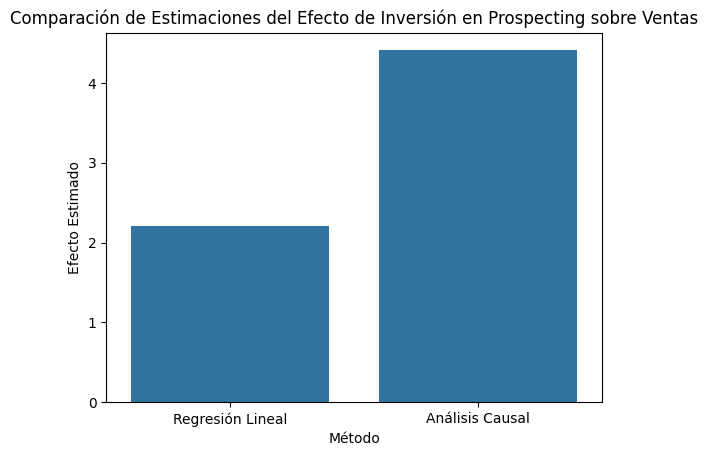

In [ ]:
# Visualización de los resultados
# Crear un DataFrame para almacenar los resultados de ambos enfoques.
resultados = pd.DataFrame({
    'Método': ['Regresión Lineal', 'Análisis Causal'],
    'Efecto de Prospecting': [coef_ct_ols, estimate_ct.value]
})

# Graficar los resultados para mostrar la diferencia entre ambos enfoques
sns.barplot(x='Método', y='Efecto de Prospecting', data=resultados)
plt.title('Comparación de Estimaciones del Efecto de Inversión en Prospecting sobre Ventas')
plt.ylabel('Efecto Estimado')
plt.show()